<a href="https://colab.research.google.com/github/dame-demi/DesignOptimization/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

The formulation for this project was a redesign of the dynamics model to more accurately portray the forces that act on the rocket when it is in its landing phase. We add a drag component to the dynamics that is then used to formulate the acceleration. 

In [20]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
DRAG_COEFFICIENT = 0.9
ROCKET_MASS = 5000
DENSITY = 0.0765
REFERENCE_AREA = 1.7
# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

We then went on to modify the forward function in the dynamics cell. We include a higher fidelity model to provide a more realistic depiction of the forces. The drag equation is given by D = 0.5 * density * coefficient of drag * velocity^2

In [21]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # Changing the equation to x[1] = x[1] + gravity * delta_time + drag * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])
        # Needed to calculate x[1]**2 but due to Pytorch used tensor operations instead. 
        v = t.dot(t.tensor([0, state[1]]), t.tensor([0, state[1]]))
        delta_state_drag = t.tensor([0., 0.5 * DENSITY * DRAG_COEFFICIENT * FRAME_TIME * REFERENCE_AREA * v / ROCKET_MASS])
        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity + delta_state_drag
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [22]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [24]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [36]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        lo = []
        for epoch in range(epochs):
            loss = self.step()
            lo.append(loss)
            print(lo)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()

[tensor(3.9077, grad_fn=<AddBackward0>)]
[1] loss: 3.908


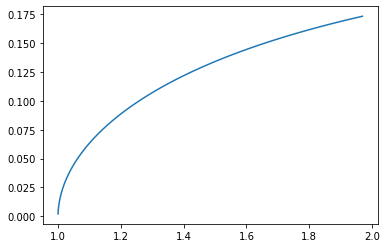

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>)]
[2] loss: 2.046


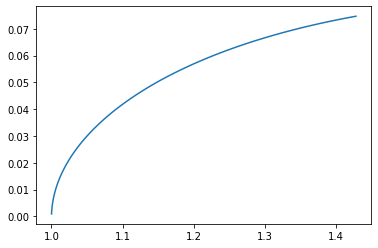

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>)]
[3] loss: 1.136


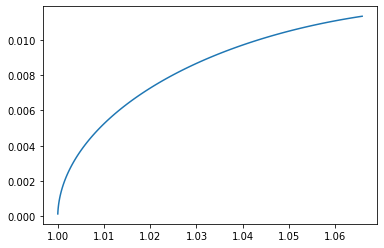

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>)]
[4] loss: 0.665


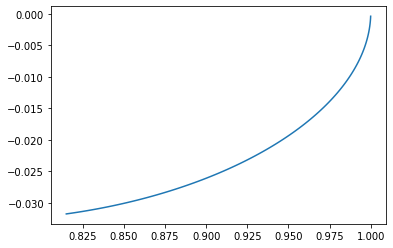

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>)]
[5] loss: 0.407


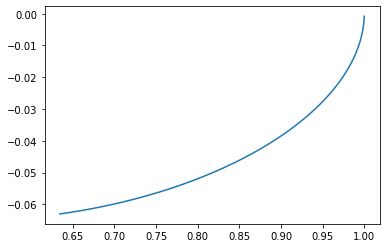

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>)]
[6] loss: 0.252


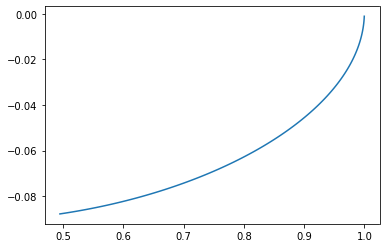

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>)]
[7] loss: 0.157


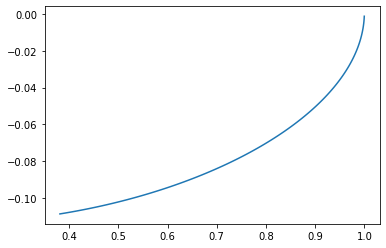

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>)]
[8] loss: 0.102


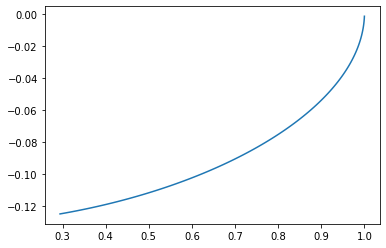

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>)]
[9] loss: 0.072


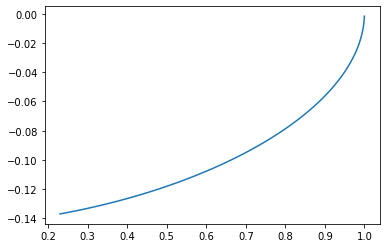

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>)]
[10] loss: 0.055


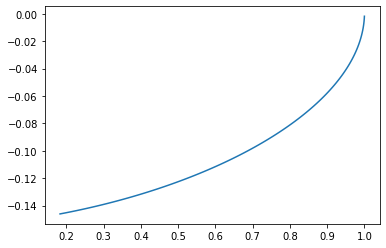

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>)]
[11] loss: 0.045


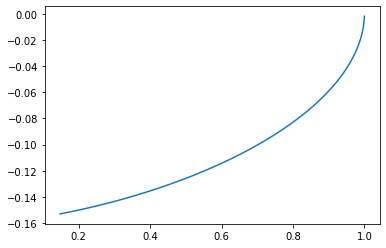

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>)]
[12] loss: 0.039


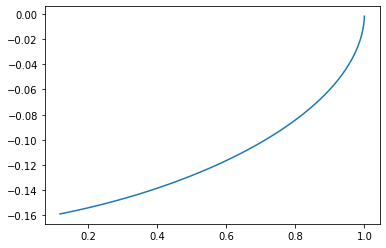

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>), tensor(0.0361, grad_fn=<AddBackward0>)]
[13] loss: 0.036


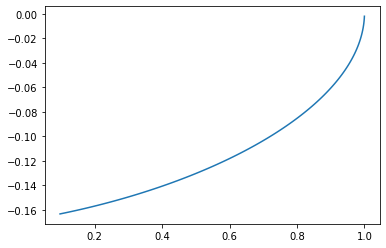

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>), tensor(0.0361, grad_fn=<AddBackward0>), tensor(0.0344, grad_fn=<AddBackward0>)]
[14] loss: 0.034


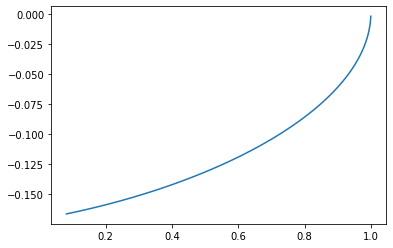

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>), tensor(0.0361, grad_fn=<AddBackward0>), tensor(0.0344, grad_fn=<AddBackward0>), tensor(0.0334, grad_fn=<AddBackward0>)]
[15] loss: 0.033


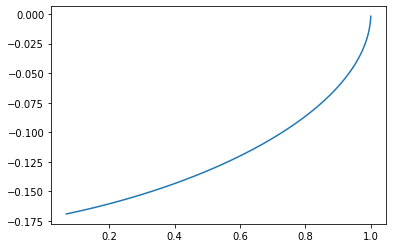

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>), tensor(0.0361, grad_fn=<AddBackward0>), tensor(0.0344, grad_fn=<AddBackward0>), tensor(0.0334, grad_fn=<AddBackward0>), tensor(0.0329, grad_fn=<AddBackward0>)]
[16] loss: 0.033


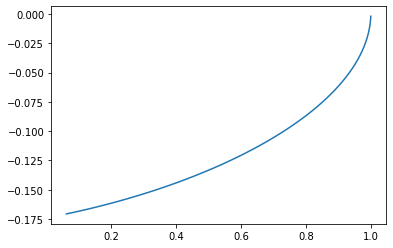

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>), tensor(0.0361, grad_fn=<AddBackward0>), tensor(0.0344, grad_fn=<AddBackward0>), tensor(0.0334, grad_fn=<AddBackward0>), tensor(0.0329, grad_fn=<AddBackward0>), tensor(0.0326, grad_fn=<AddBackward0>)]
[17] loss: 0.033


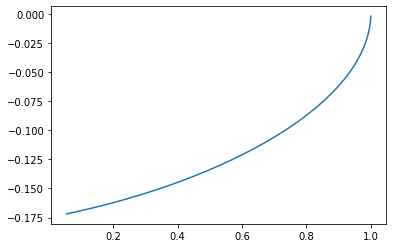

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>), tensor(0.0361, grad_fn=<AddBackward0>), tensor(0.0344, grad_fn=<AddBackward0>), tensor(0.0334, grad_fn=<AddBackward0>), tensor(0.0329, grad_fn=<AddBackward0>), tensor(0.0326, grad_fn=<AddBackward0>), tensor(0.0322, grad_fn=<AddBackward0>)]
[18] loss: 0.032


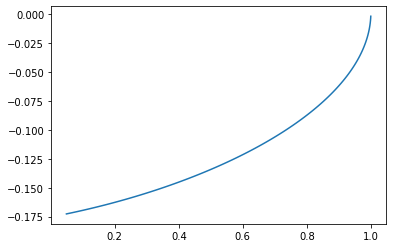

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>), tensor(0.0361, grad_fn=<AddBackward0>), tensor(0.0344, grad_fn=<AddBackward0>), tensor(0.0334, grad_fn=<AddBackward0>), tensor(0.0329, grad_fn=<AddBackward0>), tensor(0.0326, grad_fn=<AddBackward0>), tensor(0.0322, grad_fn=<AddBackward0>), tensor(0.0310, grad_fn=<AddBackward0>)]
[19] loss: 0.031


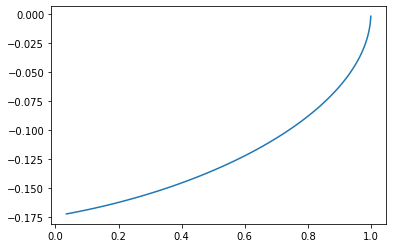

[tensor(3.9077, grad_fn=<AddBackward0>), tensor(2.0461, grad_fn=<AddBackward0>), tensor(1.1361, grad_fn=<AddBackward0>), tensor(0.6653, grad_fn=<AddBackward0>), tensor(0.4065, grad_fn=<AddBackward0>), tensor(0.2525, grad_fn=<AddBackward0>), tensor(0.1571, grad_fn=<AddBackward0>), tensor(0.1022, grad_fn=<AddBackward0>), tensor(0.0718, grad_fn=<AddBackward0>), tensor(0.0549, grad_fn=<AddBackward0>), tensor(0.0452, grad_fn=<AddBackward0>), tensor(0.0394, grad_fn=<AddBackward0>), tensor(0.0361, grad_fn=<AddBackward0>), tensor(0.0344, grad_fn=<AddBackward0>), tensor(0.0334, grad_fn=<AddBackward0>), tensor(0.0329, grad_fn=<AddBackward0>), tensor(0.0326, grad_fn=<AddBackward0>), tensor(0.0322, grad_fn=<AddBackward0>), tensor(0.0310, grad_fn=<AddBackward0>), tensor(0.0303, grad_fn=<AddBackward0>)]
[20] loss: 0.030


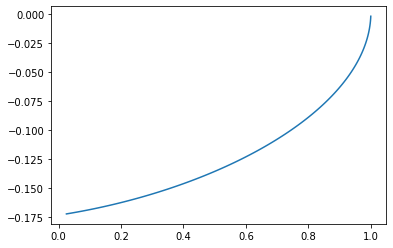

In [37]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(20)  # solve the optimization problem